In [9]:
import os
import pandas as pd
import numpy as np

# Specify the directories for the main data and labels
main_data_dir = 'action_data_11112024_unseen2'

In [4]:
import warnings

def iterate_datasets(dataset, translate_forward, translate_backward, scaled, combined, noisy, smoothened):
    for i, df in enumerate(dataset):

        def smoothen_imu_data(df, window_size=5, stride=2):
            # Define IMU columns
            imu_columns = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
            
            # Get non-IMU columns
            other_columns = [col for col in df.columns if col not in imu_columns]
            
            # Extract IMU data as numpy array
            imu_data = df[imu_columns].values
            
            # Get dimensions
            n_samples = len(imu_data)
            n_features = len(imu_columns)
            
            # Calculate number of windows
            n_windows = (n_samples - window_size) // stride + 1
            
            # Initialize output array for IMU data
            smoothened_imu = np.zeros((n_windows, n_features))
            
            # Calculate moving averages for IMU data
            for i in range(n_windows):
                start_idx = i * stride
                end_idx = start_idx + window_size
                window_data = imu_data[start_idx:end_idx]
                smoothened_imu[i] = np.mean(window_data, axis=0)
            
            # Create DataFrame with smoothened IMU data
            smoothened_df = pd.DataFrame(smoothened_imu, columns=imu_columns)
            
            # Add back other columns, taking only the relevant rows based on stride
            for col in other_columns:
                smoothened_df[col] = df[col].iloc[window_size-1:n_samples:stride].reset_index(drop=True)
            
            # Reorder columns to match input DataFrame
            smoothened_df = smoothened_df[df.columns]
            
            return smoothened_df
        #print(df)

        to_process = df.select_dtypes(include=[np.number]).columns.difference(['time', 'seq_num'])
        df = smoothen_imu_data(df[to_process])
        smoothened.append(df)
        #print("Smoothened Data: \n")
        # print(df)
        # Shift data forward by 1 row
        warnings.simplefilter(action='ignore', category=FutureWarning)
        shifted_df = df.shift(periods=1)
        reverse_shifted_df = df.shift(periods=-1)
        shifted_df.iloc[0] = df.iloc[0]  # Replace the first row with the original first row
        reverse_shifted_df.iloc[-1] = df.iloc[-1]
        translate_forward.append(shifted_df)
        translate_backward.append(reverse_shifted_df)

        shifted_df = df.shift(periods=2)
        reverse_shifted_df = df.shift(periods=-2)
        shifted_df.fillna(method='bfill', inplace=True)
        reverse_shifted_df.fillna(method='ffill', inplace=True)
        translate_forward.append(shifted_df)
        translate_backward.append(reverse_shifted_df)

        shifted_df = df.shift(periods=3)
        reverse_shifted_df = df.shift(periods=-3)
        shifted_df.fillna(method='bfill', inplace=True)
        reverse_shifted_df.fillna(method='ffill', inplace=True)
        translate_forward.append(shifted_df)
        translate_backward.append(reverse_shifted_df)

        shifted_df = df.shift(periods=4)
        reverse_shifted_df = df.shift(periods=-4)
        shifted_df.fillna(method='bfill', inplace=True)
        reverse_shifted_df.fillna(method='ffill', inplace=True)
        translate_forward.append(shifted_df)
        translate_backward.append(reverse_shifted_df)

        shifted_df = df.shift(periods=5)
        reverse_shifted_df = df.shift(periods=-5)
        shifted_df.fillna(method='bfill', inplace=True)
        reverse_shifted_df.fillna(method='ffill', inplace=True)
        translate_forward.append(shifted_df)
        translate_backward.append(reverse_shifted_df)
        # print("Translate Forward: \n")
        # print(translate_forward)
        # print("Translate Backwards: \n")
        # print(translate_backward)
        original_df = pd.DataFrame(df)
        # print(original_df)

        # Function to perform basic scaling
        def basic_scaling(signal_df, scale_factor_range=(0.8, 1.2)):
            numeric_cols = signal_df.select_dtypes(include=[np.number]).columns.difference(['time', 'seq_num'])

            ##signal_df = signal_df.apply(pd.to_numeric, errors='coerce')
            scale_factor = np.random.uniform(scale_factor_range[0], scale_factor_range[1])
            ##return signal_df * scale_factor
            # Scale only the numeric columns
            signal_df[numeric_cols] = signal_df[numeric_cols] * scale_factor
            
            return signal_df

        # Function to add noise
        def add_noise(signal_df, noise_level=0.1):
            numeric_cols = signal_df.select_dtypes(include=[np.number]).columns.difference(['time', 'seq_num'])

            ##signal_df = signal_df.apply(pd.to_numeric, errors='coerce')
            ##noise = np.random.normal(0, noise_level, signal_df.shape)
            noise = np.random.normal(0, noise_level, signal_df[numeric_cols].shape)
            ##return signal_df + noise
            signal_df[numeric_cols] = signal_df[numeric_cols] + noise
        
            return signal_df

        # Function to perform combined magnitude warping
        def combined_magnitude_warp(signal_df, scale_factor_range=(0.8, 1.2), noise_level=0.1):
            # Scale the signal
            scaled_df = basic_scaling(signal_df, scale_factor_range)
            
            # Add noise to the scaled signal
            warped_df = add_noise(scaled_df, noise_level)
            
            return warped_df

        # Generate the scaled dataset
        scaled_df = basic_scaling(original_df)
        scaled.append(scaled_df)

        # Generate the combined warped dataset (scaled + noisy)
        combined_warped_df = combined_magnitude_warp(original_df)
        combined.append(combined_warped_df)
        # Generate the noisy dataset without scaling
        noisy_df = add_noise(original_df)
        noisy.append(noisy_df)
        # break

def flatten_data(right_hand, right_leg):
    concatenated_frames = []

    # Loop through each frame (1st dimension)
    for i in range(len(right_hand)):
        axes = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
        
        filtered_df = right_hand[i][axes]
        flattened_array = filtered_df.values.flatten()
        new_column_names = [f"RIGHT_HAND_{col}_{i}" for i in range(filtered_df.shape[0]) for col in filtered_df.columns]
        flattened_hand_df = pd.DataFrame([flattened_array], columns=new_column_names)

        filtered_df_leg = right_leg[i][axes]
        flattened_array_leg = filtered_df_leg.values.flatten()
        new_column_names_leg = [f"RIGHT_LEG_{col}_{i}" for i in range(filtered_df_leg.shape[0]) for col in filtered_df_leg.columns]
        flattened_leg_df = pd.DataFrame([flattened_array_leg], columns=new_column_names_leg)

        merged_frame = pd.concat([flattened_hand_df, flattened_leg_df], axis=1)
        concatenated_frames.append(merged_frame)

    # Combine all frames into a single DataFrame
    final_df = pd.concat(concatenated_frames, ignore_index=True)
    return final_df

final_df = pd.DataFrame()

def data_augmentation(right_hand, right_leg, counter):

    global final_df
    all_actions_for_move = pd.DataFrame()
    # print(right_hand)
    # print(right_leg)
    # smoothened_data_hand = smoothen_imu_data(right_hand, window_size=5, stride=2)
    # smoothened_data_leg = smoothen_imu_data(right_leg, window_size=5, stride=2)
    # print(smoothened_data_hand)
    # print(smoothened_data_leg)
    # exit
    translate_forward_hand = []
    translate_backward_hand = []
    scaled_hand = []
    combined_hand = []
    noisy_hand = []
    smoothened_hand = []

    translate_forward_leg = []
    translate_backward_leg = []
    scaled_leg = []
    combined_leg = []
    noisy_leg = []
    smoothened_leg = []

    iterate_datasets(right_hand, translate_forward_hand, translate_backward_hand, scaled_hand, combined_hand, noisy_hand, smoothened_hand)
    iterate_datasets(right_leg, translate_forward_leg, translate_backward_leg, scaled_leg, combined_leg, noisy_leg, smoothened_leg)
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(smoothened_hand, smoothened_leg)], ignore_index=True)
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(translate_forward_hand, translate_forward_leg)], ignore_index=True)
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(translate_backward_hand, translate_backward_leg)], ignore_index=True)
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(scaled_hand, scaled_leg)], ignore_index=True)
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(combined_hand, combined_leg)], ignore_index=True)
    
    all_actions_for_move = pd.concat([all_actions_for_move, flatten_data(noisy_hand, noisy_leg)], ignore_index=True)
    all_actions_for_move['Move'] = counter

    final_df = pd.concat([all_actions_for_move, final_df], ignore_index=True)
    # print(final_df)
    

# data_augmentation(right_hand_data, right_leg_data)

In [10]:
import re

bluno1df = pd.DataFrame()
bluno3df = pd.DataFrame()
combined_df = pd.DataFrame()



os.listdir(main_data_dir)

##############################################################
# Value corresponding to each action
# Not Action = 0 # but for now this wont be included
# Basketball = 1
# Bowling = 2
# Logout = 3
# Rainbomb = 4
# Reload = 5
# Shield = 6
# Soccer = 7
# Volleyball = 8
##############################################################

def extract_number(filename):
    match = re.search(r'\d+', filename)  # Find the first sequence of digits in the filename
    return int(match.group()) if match else 0  # Convert to int, or return 0 if no match

counter = 0
# Loop through each file in the main data directory
for fileaction in os.listdir(main_data_dir):
    right_hand_data = []
    right_leg_data = []

    new_directory = os.path.join(main_data_dir, fileaction)
    print(new_directory)
    for filename in sorted(os.listdir(new_directory), key=extract_number):
        print(filename)
        if 'right_hand' in filename and filename.endswith('.csv'):
            ##print(filename)
            file_number = filename.replace('right_hand', '').replace('.csv', '')
            ##print(file_number)
            corresponding_leg_file = f'right_leg{file_number}.csv'
            leg_file_path = os.path.join(new_directory, corresponding_leg_file)
            hand_file_path = os.path.join(new_directory, filename)

            if os.path.exists(leg_file_path):
                    print(f"Found corresponding pair: {filename} and {corresponding_leg_file}")

                    # Read both the RIGHT_HAND and RIGHT_LEG CSVs
                    hand_df = pd.read_csv(hand_file_path)
                    leg_df = pd.read_csv(leg_file_path)
                    # right_hand_data.columns = ['Timestamp', 'Device', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Index']
                    # right_leg_data.columns = ['Timestamp', 'Device', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Index']
                    right_hand_data.append(hand_df)
                    right_leg_data.append(leg_df)

                    # data_augmentation(right_hand_data, right_leg_data, counter)
                    # Convert the global features to a DataFrame (1 row)
                    
                    # merged_bluno = pd.concat([bluno1_feature, bluno3_feature], axis=1)
                    # merged_bluno['Move'] = counter
                    # combined_df = pd.concat([combined_df, merged_bluno], ignore_index=True)
                    ##bluno1df = pd.concat([bluno1df, bluno1_feature], ignore_index=True)
                    ##bluno3df = pd.concat([bluno3df, bluno3_feature], ignore_index=True)
            else:
                    print(f"Corresponding RIGHT_LEG file not found for {filename}")
    
    data_augmentation(right_hand_data, right_leg_data, counter)
    counter += 1
    # break

##combined_df = pd.concat([bluno1df, bluno3df], axis=1)

action_data_11112024_unseen2\basketball
right_hand0.csv
Found corresponding pair: right_hand0.csv and right_leg0.csv
right_leg0.csv
right_hand1.csv
Found corresponding pair: right_hand1.csv and right_leg1.csv
right_leg1.csv
right_hand2.csv
Found corresponding pair: right_hand2.csv and right_leg2.csv
right_leg2.csv
right_hand3.csv
Found corresponding pair: right_hand3.csv and right_leg3.csv
right_leg3.csv
right_hand4.csv
Found corresponding pair: right_hand4.csv and right_leg4.csv
right_leg4.csv
right_hand5.csv
Found corresponding pair: right_hand5.csv and right_leg5.csv
right_leg5.csv
right_hand6.csv
Found corresponding pair: right_hand6.csv and right_leg6.csv
right_leg6.csv
right_hand7.csv
Found corresponding pair: right_hand7.csv and right_leg7.csv
right_leg7.csv
right_hand8.csv
Found corresponding pair: right_hand8.csv and right_leg8.csv
right_leg8.csv
right_hand9.csv
Found corresponding pair: right_hand9.csv and right_leg9.csv
right_leg9.csv
right_hand10.csv
Found corresponding pai

In [5]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows',None)

# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
print(final_df.shape)
final_df

(0, 0)


""


In [13]:
print(final_df['Move'].value_counts())

Move
7    588
6    588
5    588
4    588
3    588
2    588
1    588
0    588
Name: count, dtype: int64


In [14]:
# Remove rows with NaN values from the DataFrame
clean_df = final_df.dropna()

# Print the cleaned DataFrame
print(clean_df['Move'].value_counts())


Move
7    588
6    588
5    588
4    588
3    588
2    588
1    588
0    588
Name: count, dtype: int64


In [46]:
clean_df.to_csv('clean_df.csv', index=False)

In [16]:
import pandas as pd

# Basic usage
clean_df = pd.read_csv('clean_df.csv')

In [17]:
print(clean_df.shape)
clean_df

(38416, 457)


,RIGHT_HAND_Ax_0,RIGHT_HAND_Ay_0,RIGHT_HAND_Az_0,RIGHT_HAND_Gx_0,RIGHT_HAND_Gy_0,RIGHT_HAND_Gz_0,RIGHT_HAND_Ax_1,RIGHT_HAND_Ay_1,RIGHT_HAND_Az_1,RIGHT_HAND_Gx_1,...,RIGHT_LEG_Gx_36,RIGHT_LEG_Gy_36,RIGHT_LEG_Gz_36,RIGHT_LEG_Ax_37,RIGHT_LEG_Ay_37,RIGHT_LEG_Az_37,RIGHT_LEG_Gx_37,RIGHT_LEG_Gy_37,RIGHT_LEG_Gz_37,Move
0,-2984.000000,14911.200000,5520.000000,-1658.800000,-1376.200000,5344.800000,-2454.400000,16646.400000,5576.800000,-999.600000,...,-446.800000,4443.600000,-1905.800000,15796.800000,4298.400000,2952.000000,852.400000,5044.200000,-605.200000,9
1,-2314.400000,17092.000000,5096.000000,-983.600000,2582.200000,8551.000000,-1866.400000,15780.800000,5163.200000,-165.000000,...,-2763.400000,3138.200000,-1916.600000,14277.600000,6111.200000,5522.400000,-1962.200000,3869.400000,-1449.000000,9
2,-2703.200000,17410.400000,3527.200000,39.400000,4409.000000,3434.000000,-2000.800000,18254.400000,5675.200000,4354.200000,...,12857.200000,-27422.200000,2236.600000,11918.400000,3789.600000,16618.400000,6067.400000,-10854.200000,-607.200000,9
3,978.400000,16319.200000,3429.600000,-2319.200000,-1641.000000,2357.600000,206.400000,16576.800000,3651.200000,-2763.400000,...,-2200.200000,5768.400000,-393.000000,15062.400000,4648.800000,6422.400000,-2236.000000,8235.800000,-18.600000,9
4,-1732.800000,18447.200000,5168.000000,1621.200000,3462.400000,-6832.400000,-1317.600000,16045.600000,5874.400000,2718.400000,...,8392.000000,-19434.800000,904.600000,13408.800000,2316.000000,10576.800000,367.400000,-2330.400000,-2125.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38411,-9366.705990,22691.754470,-14216.935250,16953.847365,4457.838603,-6891.250970,-11603.574049,21147.523427,-16509.671919,27929.852208,...,-397.636910,-244.846139,245.575397,16345.021614,-3218.759725,6412.962730,-488.486532,-221.560814,262.379887,0
38412,-5565.228277,15767.206214,-10122.450811,11972.170941,6203.533419,-3025.240321,-5047.437202,14037.054372,-12278.280630,19917.416464,...,-272.392049,-186.774477,-105.561375,13278.800429,-2519.582538,5241.479159,-299.966564,-244.338090,-127.032763,0
38413,-3508.310925,16412.554881,-8865.370378,11424.144826,-2491.913901,-2377.193346,-4388.233514,14726.171352,-10227.014415,19434.644472,...,-220.626634,53.765389,-8.743333,14111.432788,-2840.456264,5692.589597,-258.033288,12.652425,15.532354,0
38414,-3780.273984,15874.829878,-10508.995551,9522.881600,3827.006860,-3523.179527,-5937.653127,15418.356555,-14274.915542,18089.968803,...,-248.080021,-53.161894,92.338998,14121.104905,-2823.654693,5766.472496,-277.637355,-88.489124,58.713590,0


In [18]:
## Merging clean_df with new data that we collected
combined_df = pd.concat([clean_df, final_df], axis=0, ignore_index=True)
print(combined_df)


       RIGHT_HAND_Ax_0  RIGHT_HAND_Ay_0  RIGHT_HAND_Az_0  RIGHT_HAND_Gx_0  \
0         -2984.000000     14911.200000      5520.000000     -1658.800000   
1         -2314.400000     17092.000000      5096.000000      -983.600000   
2         -2703.200000     17410.400000      3527.200000        39.400000   
3           978.400000     16319.200000      3429.600000     -2319.200000   
4         -1732.800000     18447.200000      5168.000000      1621.200000   
...                ...              ...              ...              ...   
43115    -10920.471766     17764.374841     -9700.111024     26848.402413   
43116    -17426.642853     16715.273014     -5078.838298     25839.907309   
43117     -9047.822128     10189.102871     -5022.527947     20854.732278   
43118    -20150.559378     19517.098245     -8702.164198     37718.898422   
43119      -628.442464      -902.068956     -6477.890784     -1445.658195   

       RIGHT_HAND_Gy_0  RIGHT_HAND_Gz_0  RIGHT_HAND_Ax_1  RIGHT_HAND_Ay_1  

In [148]:
## Data cleaning code jam lines below, run that before running all of these model

import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
  ## Currently set at 96, because only 2 blunos are in use
  def __init__(self, in_features=456, h1=128, h2=32, out_features=10):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.dropout = nn.Dropout(0.4)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
model = Model()
X = combined_df.drop('Move', axis=1)
y = combined_df['Move']

In [150]:
X = X.values
y = y.values

y

array([9, 9, 9, ..., 0, 0, 0], dtype=int64)

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Example feature DataFrame X and labels array y
# Assuming X is a DataFrame with your features and y is the label array
# X = pd.DataFrame(your_feature_data)
# y = np.array([...])  # Your labels as shown in the previous messages

# Stratified split into train and temp (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y, 
    test_size=0.5, 
    random_state=42, 
    stratify=y
)

# Stratified split into validation and test
X_validation, X_test, y_validation, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_validation shape: {X_validation.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_validation shape: {y_validation.shape}")
print(f"y_test shape: {y_test.shape}")

# Optionally, print counts of labels in each set
print("\nTraining labels distribution:", np.bincount(y_train))
print("Validation labels distribution:", np.bincount(y_validation))
print("Test labels distribution:", np.bincount(y_test))

X_train shape: (21560, 456)
X_validation shape: (10780, 456)
X_test shape: (10780, 456)
y_train shape: (21560,)
y_validation shape: (10780,)
y_test shape: (10780,)

Training labels distribution: [2079 2079 2086 2100 3143 3157 2086 3143 1302  385]
Validation labels distribution: [1040 1040 1043 1050 1571 1578 1043 1571  651  193]
Test labels distribution: [1039 1039 1043 1050 1572 1579 1043 1572  651  192]


In [152]:
y_train = pd.DataFrame(y_train)
y_validation = pd.DataFrame(y_validation)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
X_validation = pd.DataFrame(X_validation)
X_test = pd.DataFrame(X_test)

In [153]:
print(X_train.dtypes)

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
451    float64
452    float64
453    float64
454    float64
455    float64
Length: 456, dtype: object


In [154]:
# Convert X features to float tensors
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
X_validation = torch.FloatTensor(X_validation.values)

# Convert y labels to tensors long
y_train = torch.LongTensor(y_train.values)
y_train = y_train.squeeze()
y_test = torch.LongTensor(y_test.values)
y_test = y_test.squeeze()
y_validation = torch.LongTensor(y_validation.values)
y_validation = y_validation.squeeze()

In [155]:
y_validation

tensor([5, 1, 5,  ..., 7, 8, 2])

In [156]:
# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [178]:
# Set the number of epochs
epochs = 20
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

for i in range(epochs):
    # Training phase
    model.train()  # Set the model to training mode
    y_pred = model.forward(X_train)  # Forward pass with training data

    # Calculate training loss
    loss = criterion(y_pred, y_train)
    train_losses.append(loss.detach())  # Track the training loss

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        _, predicted_train = torch.max(y_pred, 1)  # Get the predicted class
        correct_train = (predicted_train == y_train).sum().item()  # Count correct predictions
        train_accuracy = correct_train / y_train.size(0) * 100  # Training accuracy in %
        train_accuracies.append(train_accuracy)  # Track training accuracy

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients during validation
        y_val_pred = model.forward(X_validation)  # Forward pass with validation data
        val_loss = criterion(y_val_pred, y_validation)  # Calculate validation loss
        validation_losses.append(val_loss.detach())  # Track the validation loss

        # Calculate validation accuracy
        _, predicted_val = torch.max(y_val_pred, 1)  # Get the predicted class
        correct_val = (predicted_val == y_validation).sum().item()  # Count correct predictions
        val_accuracy = correct_val / y_validation.size(0) * 100  # Validation accuracy in %
        validation_accuracies.append(val_accuracy)  # Track validation accuracy

    # Print losses and accuracies every 10 epochs
    if i % 10 == 0:
        print(f'Epoch: {i} | Training Loss: {loss:.4f} | Validation Loss: {val_loss:.4f} '
              f'| Training Accuracy: {train_accuracy:.2f}% | Validation Accuracy: {val_accuracy:.2f}%')


Epoch: 0 | Training Loss: 6.0259 | Validation Loss: 1.5308 | Training Accuracy: 84.45% | Validation Accuracy: 93.33%
Epoch: 10 | Training Loss: 5.2368 | Validation Loss: 1.3638 | Training Accuracy: 84.66% | Validation Accuracy: 93.23%


In [179]:
# Test phase
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_test_pred = model.forward(X_test)  # Forward pass with test data
    test_loss = criterion(y_test_pred, y_test)  # Calculate test loss
    print(f'Test Loss: {test_loss:.4f}')
    
    # Calculate test accuracy
    _, predicted = torch.max(y_test_pred, 1)
    correct = (predicted == y_test).sum().item()
    test_accuracy = correct / y_test.size(0) * 100
    print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 1.5460
Test Accuracy: 93.14%


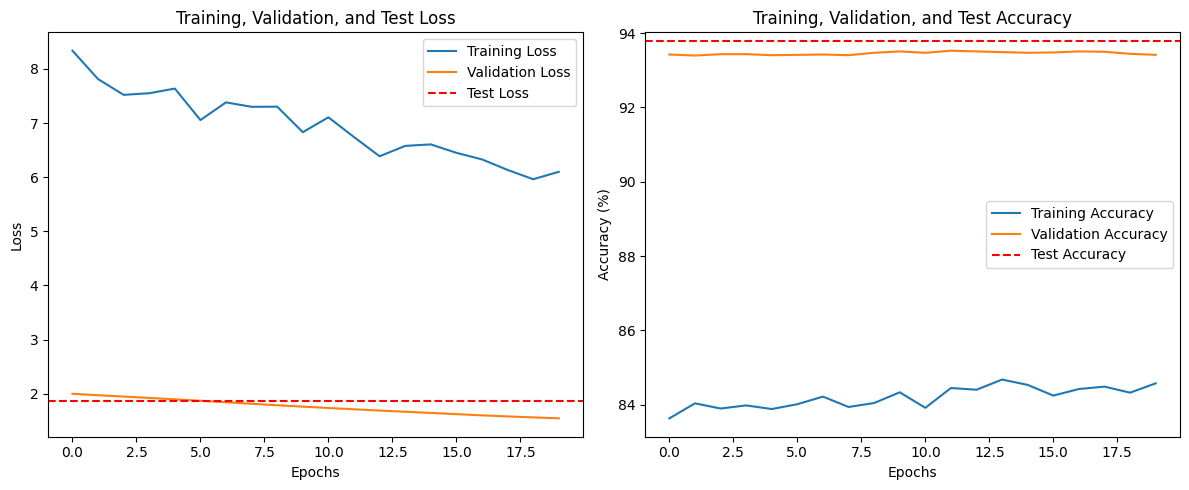

In [175]:
import matplotlib.pyplot as plt

# Plot Loss Curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Plot test loss as a horizontal line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Plot test accuracy as a horizontal line
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


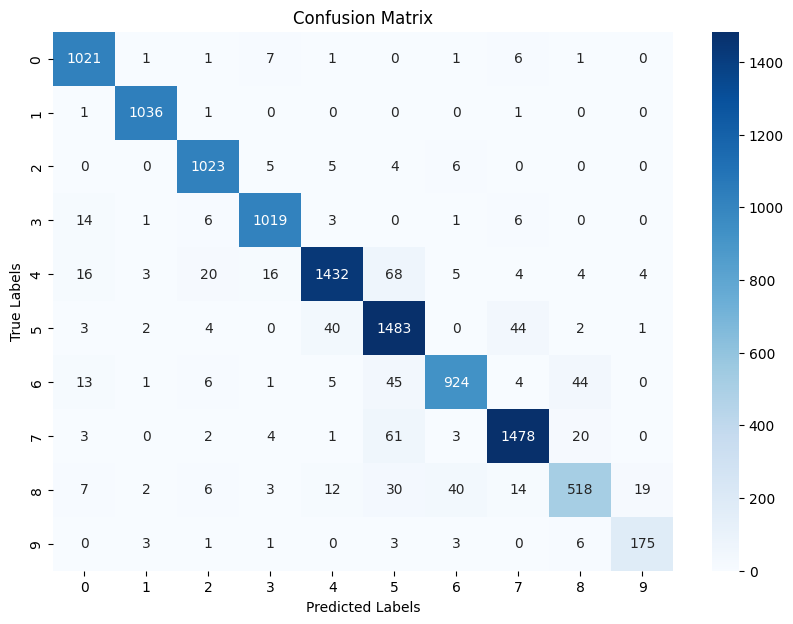

In [176]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test_np = y_test.cpu().numpy()  # Convert to NumPy array if using GPU tensors
predicted_np = predicted.cpu().numpy()

cm = confusion_matrix(y_test_np, predicted_np)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [177]:
import torch
from torch import nn
import pandas as pd

# Assuming 'model' is your MLP model
for i, layer in enumerate(model.children()):
    if isinstance(layer, nn.Linear):
        # Get weights and biases
        weights = layer.state_dict()['weight'].cpu().numpy()
        biases = layer.state_dict()['bias'].cpu().numpy()
        
        # Convert weights and biases to DataFrames
        weights_df = pd.DataFrame(weights)
        biases_df = pd.DataFrame(biases)
        
        # Define file names for CSV files
        weight_filename = f'unseen2936_{i}_weights.csv'
        bias_filename = f'unseen2936_{i}_biases.csv'
        
        # Save weights and biases to CSV files
        weights_df.to_csv(weight_filename, index=False, header=False)
        biases_df.to_csv(bias_filename, index=False, header=False)
        
        print(f'Saved weights to {weight_filename}')
        print(f'Saved biases to {bias_filename}')


Saved weights to unseen2936_0_weights.csv
Saved biases to unseen2936_0_biases.csv
Saved weights to unseen2936_2_weights.csv
Saved biases to unseen2936_2_biases.csv
Saved weights to unseen2936_3_weights.csv
Saved biases to unseen2936_3_biases.csv


In [180]:
model.eval()
logits = model(X_test)
probabilities = F.softmax(logits, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)
misclassified_indices = (predicted_labels != y_test).nonzero(as_tuple=True)[0]

# Get the predicted and true labels for these misclassified samples
misclassified_labels = predicted_labels[misclassified_indices]
true_labels = y_test[misclassified_indices]

# Retrieve the confidence scores for the predicted labels of misclassified samples
confidence_scores = probabilities[misclassified_indices, misclassified_labels]

# Display misclassified samples and their details
for i, idx in enumerate(misclassified_indices):
    print(f"Sample {idx.item()}:")
    print(f"  Predicted Label: {misclassified_labels[i].item()}")
    print(f"  True Label: {true_labels[i].item()}")
    print(f"  Confidence: {confidence_scores[i].item():.4f}")

Sample 4:
  Predicted Label: 5
  True Label: 8
  Confidence: 1.0000
Sample 14:
  Predicted Label: 2
  True Label: 3
  Confidence: 0.5838
Sample 15:
  Predicted Label: 9
  True Label: 8
  Confidence: 0.9945
Sample 26:
  Predicted Label: 8
  True Label: 6
  Confidence: 0.6126
Sample 31:
  Predicted Label: 8
  True Label: 6
  Confidence: 0.8421
Sample 33:
  Predicted Label: 5
  True Label: 2
  Confidence: 0.1104
Sample 44:
  Predicted Label: 7
  True Label: 5
  Confidence: 0.9988
Sample 56:
  Predicted Label: 5
  True Label: 4
  Confidence: 0.9907
Sample 93:
  Predicted Label: 4
  True Label: 6
  Confidence: 0.5810
Sample 121:
  Predicted Label: 9
  True Label: 8
  Confidence: 0.6605
Sample 124:
  Predicted Label: 7
  True Label: 5
  Confidence: 0.3875
Sample 129:
  Predicted Label: 2
  True Label: 4
  Confidence: 0.9992
Sample 133:
  Predicted Label: 5
  True Label: 7
  Confidence: 0.9652
Sample 139:
  Predicted Label: 2
  True Label: 5
  Confidence: 0.9569
Sample 188:
  Predicted Label:

In [181]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.optimize import minimize

class TemperatureScaling:
    def __init__(self):
        self.temperature = None

    def fit(self, logits, true_labels):
        # Objective function to minimize (Negative log likelihood)
        def nll(temp):
            scaled_logits = logits / temp
            loss = F.cross_entropy(scaled_logits, true_labels)
            return loss.item()

        # Optimize temperature
        initial_temp = np.ones(1)  # Initial guess
        result = minimize(nll, initial_temp, bounds=[(1e-5, None)])  # Avoid zero temperature
        self.temperature = result.x[0]

    def predict(self, logits):
        return F.softmax(logits / self.temperature, dim=1)

# Assuming model, X_validation, and y_validation are defined
model.eval()
with torch.no_grad():
    # Get logits for the validation set
    validation_logits = model(X_validation)

# Fit temperature scaling
temperature_scaling = TemperatureScaling()
temperature_scaling.fit(validation_logits, y_validation)

# Assuming X_test and y_test are defined
with torch.no_grad():
    # Get logits for the test set
    test_logits = model(X_test)
    # Apply temperature scaling
    probabilities = temperature_scaling.predict(test_logits)
    predicted_labels = torch.argmax(probabilities, dim=1)

# Misclassification analysis
misclassified_indices = (predicted_labels != y_test).nonzero(as_tuple=True)[0]
misclassified_labels = predicted_labels[misclassified_indices]
true_labels = y_test[misclassified_indices]
confidence_scores = probabilities[misclassified_indices, misclassified_labels]

# Display misclassified samples and their details
for i, idx in enumerate(misclassified_indices):
    print(f"Sample {idx.item()}:")
    print(f"  Predicted Label: {misclassified_labels[i].item()}")
    print(f"  True Label: {true_labels[i].item()}")
    print(f"  Confidence: {confidence_scores[i].item():.4f}")

# Now let's extract correct predictions for further analysis
correct_indices = (predicted_labels == y_test).nonzero(as_tuple=True)[0]
correct_confidences = probabilities[correct_indices, predicted_labels[correct_indices]]

Sample 4:
  Predicted Label: 5
  True Label: 8
  Confidence: 0.9065
Sample 14:
  Predicted Label: 2
  True Label: 3
  Confidence: 0.4680
Sample 15:
  Predicted Label: 9
  True Label: 8
  Confidence: 0.3976
Sample 26:
  Predicted Label: 8
  True Label: 6
  Confidence: 0.1483
Sample 31:
  Predicted Label: 8
  True Label: 6
  Confidence: 0.3542
Sample 33:
  Predicted Label: 5
  True Label: 2
  Confidence: 0.1009
Sample 44:
  Predicted Label: 7
  True Label: 5
  Confidence: 0.4131
Sample 56:
  Predicted Label: 5
  True Label: 4
  Confidence: 0.4762
Sample 93:
  Predicted Label: 4
  True Label: 6
  Confidence: 0.1992
Sample 121:
  Predicted Label: 9
  True Label: 8
  Confidence: 0.1890
Sample 124:
  Predicted Label: 7
  True Label: 5
  Confidence: 0.2584
Sample 129:
  Predicted Label: 2
  True Label: 4
  Confidence: 0.4627
Sample 133:
  Predicted Label: 5
  True Label: 7
  Confidence: 0.4775
Sample 139:
  Predicted Label: 2
  True Label: 5
  Confidence: 0.2456
Sample 188:
  Predicted Label:

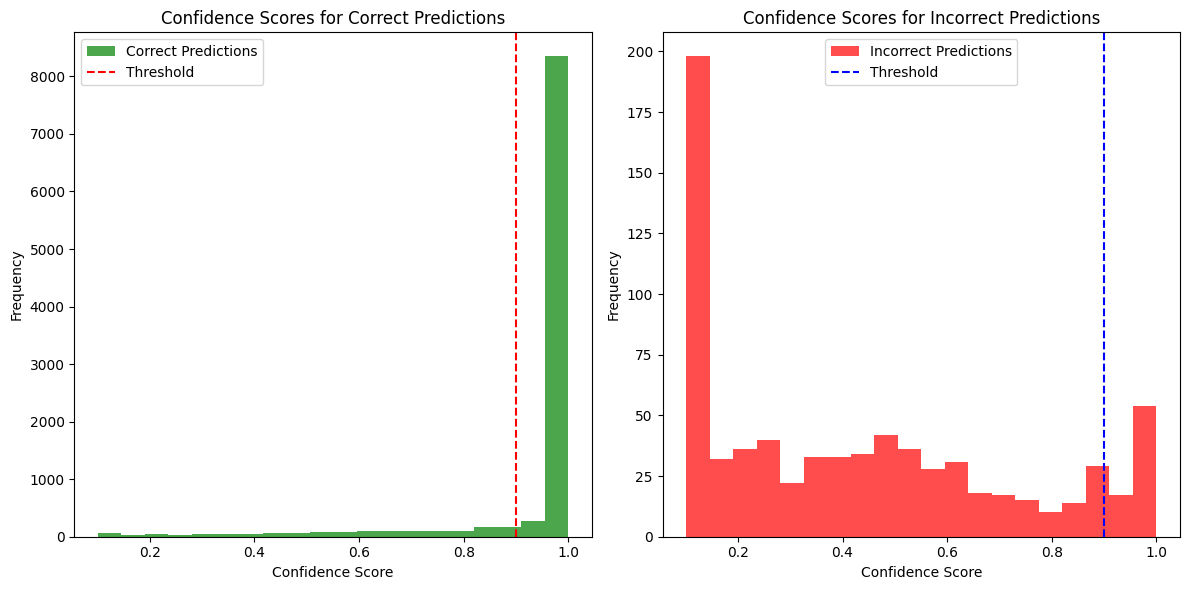

In [182]:
import matplotlib.pyplot as plt

# Plotting the confidence scores
plt.figure(figsize=(12, 6))

# Histogram for correct predictions
plt.subplot(1, 2, 1)
plt.hist(correct_confidences.detach().numpy(), bins=20, color='green', alpha=0.7, label='Correct Predictions')
plt.axvline(x=0.9, color='red', linestyle='--', label='Threshold')
plt.title('Confidence Scores for Correct Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Histogram for incorrect predictions
incorrect_confidences = probabilities[misclassified_indices, misclassified_labels]
plt.subplot(1, 2, 2)
plt.hist(incorrect_confidences.detach().numpy(), bins=20, color='red', alpha=0.7, label='Incorrect Predictions')
plt.axvline(x=0.9, color='blue', linestyle='--', label='Threshold')
plt.title('Confidence Scores for Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
import pandas as pd

# Define the MLP model structure based on your architecture
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Apply activation for all but the output layer
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the layer sizes as per your model architecture
layer_sizes = [960, 128, 32, 10]  # Replace with actual sizes
mlp_model = MLP(layer_sizes)

# Load weights and biases from separate CSV files for each layer
with torch.no_grad():
    layer_index = 0
    for layer in mlp_model.model:
        if isinstance(layer, nn.Linear):
            # Load weights from 2_player_v1_{layer_index}_weights.csv
            weights_file = f"2_player_final964_{layer_index}_weights.csv"
            weights_data = pd.read_csv(weights_file, header=None)  # No header if pure matrix format
            weights = torch.tensor(weights_data.values, dtype=torch.float32)
            
            # Load biases from 2_player_v1_{layer_index}_biases.csv
            biases_file = f"2_player_final964_{layer_index}_biases.csv"
            biases_data = pd.read_csv(biases_file, header=None)
            biases = torch.tensor(biases_data.values.squeeze(), dtype=torch.float32)  # Squeeze if biases are single column

            # Assign weights and biases to the model layer
            layer.weight = nn.Parameter(weights)
            layer.bias = nn.Parameter(biases)
            
            layer_index += 1

In [ ]:
import torch

# Convert input data to a PyTorch tensor
input_data = torch.tensor([[-1.7112e+03,  2.8304e+03,  3.2560e+03,  2.5676e+04, -5.6894e+03,
    		         5.8414e+03, -1.9352e+03, -3.4616e+03,  3.2728e+03,  1.2654e+04,
    		        -6.3542e+03,  2.5886e+03, -2.3688e+03, -4.2400e+03,  2.3568e+03,
    		        -6.6010e+03,  1.9380e+02, -6.1200e+02, -2.1600e+03,  8.2560e+02,
    		         1.8432e+03, -2.3886e+04,  4.8566e+03, -5.0038e+03, -2.3648e+03,
    		         1.0078e+04, -5.7840e+02, -3.1154e+04, -5.4238e+03, -8.1300e+03,
    		        -5.1032e+03,  1.9982e+04, -4.6376e+03, -3.2768e+04, -1.6078e+04,
    		        -7.3992e+03, -8.3384e+03,  2.6426e+04, -8.7344e+03, -3.2768e+04,
    		        -1.2812e+04, -2.6616e+03, -8.2720e+03,  2.8754e+04, -1.1733e+04,
    		        -3.0692e+04,  1.1288e+03,  1.4440e+03, -6.0600e+03,  2.7573e+04,
    		        -1.2280e+04, -2.6719e+04,  8.2884e+03,  2.6948e+03, -3.3712e+03,
    		         2.5741e+04, -1.4022e+04, -2.2121e+04,  1.0491e+04, -7.5000e+01,
    		        -2.3824e+03,  2.4529e+04, -1.1129e+04, -1.1319e+04,  1.9060e+04,
    		         1.7232e+03, -4.8240e+02,  2.0883e+04, -6.8056e+03,  4.4600e+01,
    		         2.0230e+04,  4.0440e+03, -9.9200e+01,  1.5315e+04,  1.8008e+03,
    		         6.7316e+03,  1.0420e+04,  3.7486e+03, -1.1056e+03,  1.4097e+04,
    		         1.3864e+03,  1.9324e+03, -1.5676e+03,  6.8360e+02, -2.2064e+03,
    		         1.5030e+04,  9.4000e+02, -1.1118e+03, -7.1500e+03,  9.6080e+02,
    		        -2.9488e+03,  1.5884e+04, -6.8000e+01, -1.9968e+03, -5.1178e+03,
    		         1.3434e+03, -3.1136e+03,  1.6326e+04, -9.9520e+02, -2.9190e+03,
    		         1.6400e+01,  1.4898e+03, -2.3904e+03,  1.6228e+04, -1.2008e+03,
    		        -2.6968e+03,  2.7876e+03,  1.2680e+03, -1.7552e+03,  1.6338e+04,
    		        -9.7760e+02, -1.7136e+03,  8.3680e+02,  5.9540e+02, -1.4840e+03,
    		         1.6310e+04, -1.0632e+03, -7.0700e+02, -1.9324e+03, -1.4820e+02,
    		        -1.6280e+03,  1.6298e+04, -1.0408e+03, -1.8560e+02, -3.2354e+03,
    		        -4.2120e+02, -1.9104e+03,  1.6180e+04, -8.0960e+02,  9.7200e+01,
    		        -3.7876e+03, -3.8520e+02, -2.3112e+03,  1.6010e+04, -6.5760e+02,
    		         2.3380e+02, -3.6308e+03, -5.0360e+02, -2.4368e+03,  1.5862e+04,
    		        -6.1440e+02, -3.2800e+01, -2.3266e+03, -4.3360e+02, -2.3432e+03,
    		         1.5838e+04, -5.8800e+02, -4.6100e+02, -9.9900e+02, -2.5300e+02,
    		        -2.2808e+03,  1.5975e+04, -6.3600e+02, -8.2900e+02, -6.8000e+01,
    		        -1.2660e+02, -2.1824e+03,  1.6124e+04, -6.8080e+02, -6.9240e+02,
    		         8.0480e+02, -1.6880e+02, -1.9384e+03,  1.6188e+04, -6.0000e+02,
    		        -5.0260e+02,  1.0064e+03, -1.5280e+02, -1.8232e+03,  1.6116e+04,
    		        -5.4320e+02, -1.4020e+02,  4.2380e+02, -1.1060e+02, -1.8544e+03,
    		         1.6048e+04, -5.0160e+02, -2.1200e+02, -1.6380e+02, -8.8600e+01,
    		        -1.9520e+03,  1.5982e+04, -4.9600e+02, -3.4120e+02, -1.6240e+02,
    		        -6.3400e+01, -1.9624e+03,  1.5974e+04, -5.2560e+02, -5.9660e+02,
    		        -1.5260e+02, -3.7400e+01, -2.0104e+03,  1.5990e+04, -6.9280e+02,
    		        -5.8380e+02, -4.8320e+02, -1.1740e+02, -2.0104e+03,  1.5990e+04,
    		        -6.9280e+02, -5.8380e+02, -4.8320e+02, -1.1740e+02, -2.0104e+03,
    		         1.5990e+04, -6.9280e+02, -5.8380e+02, -4.8320e+02, -1.1740e+02,
    		        -2.0104e+03,  1.5990e+04, -6.9280e+02, -5.8380e+02, -4.8320e+02,
    		        -1.1740e+02, -2.0104e+03,  1.5990e+04, -6.9280e+02, -5.8380e+02,
    		        -4.8320e+02, -1.1740e+02, -2.0104e+03,  1.5990e+04, -6.9280e+02,
    		        -5.8380e+02, -4.8320e+02, -1.1740e+02,  1.5871e+04, -1.1880e+03,
    		         5.5272e+03, -3.7700e+02, -6.2160e+02, -1.9620e+02,  1.5863e+04,
    		        -1.1048e+03,  5.5552e+03, -3.2040e+02, -6.2840e+02, -2.0380e+02,
    		         1.5876e+04, -9.4400e+02,  5.5296e+03, -3.9640e+02, -7.2200e+02,
    		        -9.0600e+01,  1.5906e+04, -8.7760e+02,  5.4872e+03, -4.4080e+02,
    		        -8.7460e+02,  1.0220e+02,  1.5920e+04, -9.7760e+02,  5.5072e+03,
    		        -4.4580e+02, -1.1372e+03,  2.9140e+02,  1.5990e+04, -1.1216e+03,
    		         5.2048e+03, -3.7720e+02, -1.2956e+03,  3.5840e+02,  1.6135e+04,
    		        -1.2856e+03,  4.7864e+03, -2.0900e+02, -9.8900e+02,  2.5100e+02,
    		         1.6159e+04, -1.2304e+03,  4.7304e+03, -1.1320e+02, -4.1720e+02,
    		         8.8000e+01,  1.6084e+04, -1.0760e+03,  5.0080e+03, -2.3260e+02,
    		        -1.4080e+02,  6.1600e+01,  1.6043e+04, -9.8400e+02,  5.1280e+03,
    		        -5.5140e+02, -2.4200e+02,  2.0120e+02,  1.6037e+04, -1.1368e+03,
    		         5.0800e+03, -6.9740e+02, -3.7520e+02,  4.3620e+02,  1.6062e+04,
    		        -1.2560e+03,  4.9336e+03, -7.0940e+02, -4.3960e+02,  4.7320e+02,
    		         1.6058e+04, -1.6016e+03,  4.9720e+03, -5.9000e+02, -4.0080e+02,
    		         3.1320e+02,  1.6098e+04, -1.4632e+03,  4.9088e+03, -5.4240e+02,
    		        -3.0520e+02,  1.7080e+02,  1.6059e+04, -1.4648e+03,  4.9176e+03,
    		        -4.4600e+02, -2.9260e+02,  8.8200e+01,  1.6065e+04, -1.3632e+03,
    		         4.8816e+03, -4.2560e+02, -2.7240e+02,  9.2800e+01,  1.6072e+04,
    		        -1.3976e+03,  4.9224e+03, -4.0900e+02, -2.2040e+02,  1.1200e+02,
    		         1.6046e+04, -1.4112e+03,  4.9784e+03, -4.0620e+02, -1.3960e+02,
    		         9.5000e+01,  1.5997e+04, -1.4376e+03,  5.0976e+03, -4.5340e+02,
    		        -8.4200e+01,  4.7200e+01,  1.6006e+04, -1.4368e+03,  5.0704e+03,
    		        -4.8260e+02, -1.3400e+02,  4.2400e+01,  1.6021e+04, -1.4560e+03,
    		         5.0128e+03, -4.6360e+02, -1.9660e+02,  3.0200e+01,  1.6014e+04,
    		        -1.4440e+03,  4.9720e+03, -4.5720e+02, -1.5760e+02, -3.2400e+01,
    		         1.5990e+04, -1.4336e+03,  5.0664e+03, -4.1940e+02, -1.4180e+02,
    		        -4.9400e+01,  1.5966e+04, -1.4136e+03,  5.1424e+03, -3.4120e+02,
    		        -2.1720e+02,  2.2000e+00,  1.5979e+04, -1.4152e+03,  5.1336e+03,
    		        -2.6480e+02, -2.6960e+02,  1.5800e+01,  1.6006e+04, -1.4040e+03,
    		         5.1104e+03, -2.2540e+02, -2.5920e+02,  3.1200e+01,  1.6011e+04,
    		        -1.3080e+03,  5.1616e+03, -2.2800e+02, -2.3320e+02,  3.1600e+01,
    		         1.6009e+04, -1.3072e+03,  5.1984e+03, -3.0400e+02, -2.2660e+02,
    		         3.7000e+01,  1.6025e+04, -1.3184e+03,  5.1784e+03, -3.5220e+02,
    		        -2.2820e+02,  2.4400e+01,  1.5978e+04, -1.3704e+03,  5.1952e+03,
    		        -3.7500e+02, -2.3260e+02,  1.7200e+01,  1.5943e+04, -1.3808e+03,
    		         5.1696e+03, -3.2160e+02, -2.1020e+02,  1.2400e+01,  1.5981e+04,
    		        -1.3544e+03,  5.1480e+03, -2.8900e+02, -1.6120e+02,  1.3000e+01,
    		         1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02,
    		        -5.2000e+00,  1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02,
    		        -1.3160e+02, -5.2000e+00,  1.5998e+04, -1.3448e+03,  5.1296e+03,
    		        -3.0680e+02, -1.3160e+02, -5.2000e+00,  1.5998e+04, -1.3448e+03,
    		         5.1296e+03, -3.0680e+02, -1.3160e+02, -5.2000e+00,  1.5998e+04,
    		        -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02, -5.2000e+00,
    		         1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02,
    		        -5.2000e+00]], dtype=torch.float32)

# Ensure the model is in evaluation mode
mlp_model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Perform a forward pass
    output = mlp_model(input_data)

# Print the output
print(output)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x960 and 456x128)

In [2]:
X_test

NameError: name 'X_test' is not defined

In [147]:
# Get all values of the first row in X_test
first_row = X_test[0]
print(first_row)


tensor([-1.7112e+03,  2.8304e+03,  3.2560e+03,  2.5676e+04, -5.6894e+03,
         5.8414e+03, -1.9352e+03, -3.4616e+03,  3.2728e+03,  1.2654e+04,
        -6.3542e+03,  2.5886e+03, -2.3688e+03, -4.2400e+03,  2.3568e+03,
        -6.6010e+03,  1.9380e+02, -6.1200e+02, -2.1600e+03,  8.2560e+02,
         1.8432e+03, -2.3886e+04,  4.8566e+03, -5.0038e+03, -2.3648e+03,
         1.0078e+04, -5.7840e+02, -3.1154e+04, -5.4238e+03, -8.1300e+03,
        -5.1032e+03,  1.9982e+04, -4.6376e+03, -3.2768e+04, -1.6078e+04,
        -7.3992e+03, -8.3384e+03,  2.6426e+04, -8.7344e+03, -3.2768e+04,
        -1.2812e+04, -2.6616e+03, -8.2720e+03,  2.8754e+04, -1.1733e+04,
        -3.0692e+04,  1.1288e+03,  1.4440e+03, -6.0600e+03,  2.7573e+04,
        -1.2280e+04, -2.6719e+04,  8.2884e+03,  2.6948e+03, -3.3712e+03,
         2.5741e+04, -1.4022e+04, -2.2121e+04,  1.0491e+04, -7.5000e+01,
        -2.3824e+03,  2.4529e+04, -1.1129e+04, -1.1319e+04,  1.9060e+04,
         1.7232e+03, -4.8240e+02,  2.0883e+04, -6.8

In [183]:
import torch

# Convert input data to a PyTorch tensor
input_data = torch.tensor([[-1.7112e+03,  2.8304e+03,  3.2560e+03,  2.5676e+04, -5.6894e+03,
         5.8414e+03, -1.9352e+03, -3.4616e+03,  3.2728e+03,  1.2654e+04,
        -6.3542e+03,  2.5886e+03, -2.3688e+03, -4.2400e+03,  2.3568e+03,
        -6.6010e+03,  1.9380e+02, -6.1200e+02, -2.1600e+03,  8.2560e+02,
         1.8432e+03, -2.3886e+04,  4.8566e+03, -5.0038e+03, -2.3648e+03,
         1.0078e+04, -5.7840e+02, -3.1154e+04, -5.4238e+03, -8.1300e+03,
        -5.1032e+03,  1.9982e+04, -4.6376e+03, -3.2768e+04, -1.6078e+04,
        -7.3992e+03, -8.3384e+03,  2.6426e+04, -8.7344e+03, -3.2768e+04,
        -1.2812e+04, -2.6616e+03, -8.2720e+03,  2.8754e+04, -1.1733e+04,
        -3.0692e+04,  1.1288e+03,  1.4440e+03, -6.0600e+03,  2.7573e+04,
        -1.2280e+04, -2.6719e+04,  8.2884e+03,  2.6948e+03, -3.3712e+03,
         2.5741e+04, -1.4022e+04, -2.2121e+04,  1.0491e+04, -7.5000e+01,
        -2.3824e+03,  2.4529e+04, -1.1129e+04, -1.1319e+04,  1.9060e+04,
         1.7232e+03, -4.8240e+02,  2.0883e+04, -6.8056e+03,  4.4600e+01,
         2.0230e+04,  4.0440e+03, -9.9200e+01,  1.5315e+04,  1.8008e+03,
         6.7316e+03,  1.0420e+04,  3.7486e+03, -1.1056e+03,  1.4097e+04,
         1.3864e+03,  1.9324e+03, -1.5676e+03,  6.8360e+02, -2.2064e+03,
         1.5030e+04,  9.4000e+02, -1.1118e+03, -7.1500e+03,  9.6080e+02,
        -2.9488e+03,  1.5884e+04, -6.8000e+01, -1.9968e+03, -5.1178e+03,
         1.3434e+03, -3.1136e+03,  1.6326e+04, -9.9520e+02, -2.9190e+03,
         1.6400e+01,  1.4898e+03, -2.3904e+03,  1.6228e+04, -1.2008e+03,
        -2.6968e+03,  2.7876e+03,  1.2680e+03, -1.7552e+03,  1.6338e+04,
        -9.7760e+02, -1.7136e+03,  8.3680e+02,  5.9540e+02, -1.4840e+03,
         1.6310e+04, -1.0632e+03, -7.0700e+02, -1.9324e+03, -1.4820e+02,
        -1.6280e+03,  1.6298e+04, -1.0408e+03, -1.8560e+02, -3.2354e+03,
        -4.2120e+02, -1.9104e+03,  1.6180e+04, -8.0960e+02,  9.7200e+01,
        -3.7876e+03, -3.8520e+02, -2.3112e+03,  1.6010e+04, -6.5760e+02,
         2.3380e+02, -3.6308e+03, -5.0360e+02, -2.4368e+03,  1.5862e+04,
        -6.1440e+02, -3.2800e+01, -2.3266e+03, -4.3360e+02, -2.3432e+03,
         1.5838e+04, -5.8800e+02, -4.6100e+02, -9.9900e+02, -2.5300e+02,
        -2.2808e+03,  1.5975e+04, -6.3600e+02, -8.2900e+02, -6.8000e+01,
        -1.2660e+02, -2.1824e+03,  1.6124e+04, -6.8080e+02, -6.9240e+02,
         8.0480e+02, -1.6880e+02, -1.9384e+03,  1.6188e+04, -6.0000e+02,
        -5.0260e+02,  1.0064e+03, -1.5280e+02, -1.8232e+03,  1.6116e+04,
        -5.4320e+02, -1.4020e+02,  4.2380e+02, -1.1060e+02, -1.8544e+03,
         1.6048e+04, -5.0160e+02, -2.1200e+02, -1.6380e+02, -8.8600e+01,
        -1.9520e+03,  1.5982e+04, -4.9600e+02, -3.4120e+02, -1.6240e+02,
        -6.3400e+01, -1.9624e+03,  1.5974e+04, -5.2560e+02, -5.9660e+02,
        -1.5260e+02, -3.7400e+01, -2.0104e+03,  1.5990e+04, -6.9280e+02,
        -5.8380e+02, -4.8320e+02, -1.1740e+02, -2.0104e+03,  1.5990e+04,
        -6.9280e+02, -5.8380e+02, -4.8320e+02, -1.1740e+02, -2.0104e+03,
         1.5990e+04, -6.9280e+02, -5.8380e+02, -4.8320e+02, -1.1740e+02,
        -2.0104e+03,  1.5990e+04, -6.9280e+02, -5.8380e+02, -4.8320e+02,
        -1.1740e+02, -2.0104e+03,  1.5990e+04, -6.9280e+02, -5.8380e+02,
        -4.8320e+02, -1.1740e+02, -2.0104e+03,  1.5990e+04, -6.9280e+02,
        -5.8380e+02, -4.8320e+02, -1.1740e+02,  1.5871e+04, -1.1880e+03,
         5.5272e+03, -3.7700e+02, -6.2160e+02, -1.9620e+02,  1.5863e+04,
        -1.1048e+03,  5.5552e+03, -3.2040e+02, -6.2840e+02, -2.0380e+02,
         1.5876e+04, -9.4400e+02,  5.5296e+03, -3.9640e+02, -7.2200e+02,
        -9.0600e+01,  1.5906e+04, -8.7760e+02,  5.4872e+03, -4.4080e+02,
        -8.7460e+02,  1.0220e+02,  1.5920e+04, -9.7760e+02,  5.5072e+03,
        -4.4580e+02, -1.1372e+03,  2.9140e+02,  1.5990e+04, -1.1216e+03,
         5.2048e+03, -3.7720e+02, -1.2956e+03,  3.5840e+02,  1.6135e+04,
        -1.2856e+03,  4.7864e+03, -2.0900e+02, -9.8900e+02,  2.5100e+02,
         1.6159e+04, -1.2304e+03,  4.7304e+03, -1.1320e+02, -4.1720e+02,
         8.8000e+01,  1.6084e+04, -1.0760e+03,  5.0080e+03, -2.3260e+02,
        -1.4080e+02,  6.1600e+01,  1.6043e+04, -9.8400e+02,  5.1280e+03,
        -5.5140e+02, -2.4200e+02,  2.0120e+02,  1.6037e+04, -1.1368e+03,
         5.0800e+03, -6.9740e+02, -3.7520e+02,  4.3620e+02,  1.6062e+04,
        -1.2560e+03,  4.9336e+03, -7.0940e+02, -4.3960e+02,  4.7320e+02,
         1.6058e+04, -1.6016e+03,  4.9720e+03, -5.9000e+02, -4.0080e+02,
         3.1320e+02,  1.6098e+04, -1.4632e+03,  4.9088e+03, -5.4240e+02,
        -3.0520e+02,  1.7080e+02,  1.6059e+04, -1.4648e+03,  4.9176e+03,
        -4.4600e+02, -2.9260e+02,  8.8200e+01,  1.6065e+04, -1.3632e+03,
         4.8816e+03, -4.2560e+02, -2.7240e+02,  9.2800e+01,  1.6072e+04,
        -1.3976e+03,  4.9224e+03, -4.0900e+02, -2.2040e+02,  1.1200e+02,
         1.6046e+04, -1.4112e+03,  4.9784e+03, -4.0620e+02, -1.3960e+02,
         9.5000e+01,  1.5997e+04, -1.4376e+03,  5.0976e+03, -4.5340e+02,
        -8.4200e+01,  4.7200e+01,  1.6006e+04, -1.4368e+03,  5.0704e+03,
        -4.8260e+02, -1.3400e+02,  4.2400e+01,  1.6021e+04, -1.4560e+03,
         5.0128e+03, -4.6360e+02, -1.9660e+02,  3.0200e+01,  1.6014e+04,
        -1.4440e+03,  4.9720e+03, -4.5720e+02, -1.5760e+02, -3.2400e+01,
         1.5990e+04, -1.4336e+03,  5.0664e+03, -4.1940e+02, -1.4180e+02,
        -4.9400e+01,  1.5966e+04, -1.4136e+03,  5.1424e+03, -3.4120e+02,
        -2.1720e+02,  2.2000e+00,  1.5979e+04, -1.4152e+03,  5.1336e+03,
        -2.6480e+02, -2.6960e+02,  1.5800e+01,  1.6006e+04, -1.4040e+03,
         5.1104e+03, -2.2540e+02, -2.5920e+02,  3.1200e+01,  1.6011e+04,
        -1.3080e+03,  5.1616e+03, -2.2800e+02, -2.3320e+02,  3.1600e+01,
         1.6009e+04, -1.3072e+03,  5.1984e+03, -3.0400e+02, -2.2660e+02,
         3.7000e+01,  1.6025e+04, -1.3184e+03,  5.1784e+03, -3.5220e+02,
        -2.2820e+02,  2.4400e+01,  1.5978e+04, -1.3704e+03,  5.1952e+03,
        -3.7500e+02, -2.3260e+02,  1.7200e+01,  1.5943e+04, -1.3808e+03,
         5.1696e+03, -3.2160e+02, -2.1020e+02,  1.2400e+01,  1.5981e+04,
        -1.3544e+03,  5.1480e+03, -2.8900e+02, -1.6120e+02,  1.3000e+01,
         1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02,
        -5.2000e+00,  1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02,
        -1.3160e+02, -5.2000e+00,  1.5998e+04, -1.3448e+03,  5.1296e+03,
        -3.0680e+02, -1.3160e+02, -5.2000e+00,  1.5998e+04, -1.3448e+03,
         5.1296e+03, -3.0680e+02, -1.3160e+02, -5.2000e+00,  1.5998e+04,
        -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02, -5.2000e+00,
         1.5998e+04, -1.3448e+03,  5.1296e+03, -3.0680e+02, -1.3160e+02,
        -5.2000e+00]], dtype=torch.float32)

# Ensure the model is in evaluation mode
model.eval()

# Disable gradient calculations for inference
with torch.no_grad():
    # Perform a forward pass
    output = model(input_data)

# Print the output
print(output)

tensor([[-11.8120, -10.2643,   4.5915,  -2.8098,  -5.0796, -10.0407,  -5.3675,
         -11.4128,   6.4740,  -7.2638]])
